[**Dataset Link**](https://drive.google.com/file/d/1M_dwAJt0SeNr0lj1G5ZzA-9dlULi6BnC/view)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?id=1M_dwAJt0SeNr0lj1G5ZzA-9dlULi6BnC', sep=';', quotechar='"')

In [ ]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [ ]:
# Map y: yes/no -> 1/0
y = df['y'].astype(str).str.lower().map({'yes':1, 'no':0}).astype(int)
X = df[['campaign']].copy()

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
# McFadden pseudo-R^2
def mcfadden_r2(y_true, p_pred, p_null):
    eps = 1e-15
    p = np.clip(p_pred, eps, 1-eps)
    ll_model = np.sum(y_true*np.log(p) + (1-y_true)*np.log(1-p))
    p0 = np.clip(p_null, eps, 1-eps)
    ll_null = np.sum(y_true*np.log(p0) + (1-y_true)*np.log(1-p0))
    return 1 - (ll_model/ll_null)

In [ ]:
# Logistic Regression
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)
proba_log = log_clf.predict_proba(X_test)[:,1]
pred_log = (proba_log >= 0.5).astype(int)

acc_log = accuracy_score(y_test, pred_log)
auc_log = roc_auc_score(y_test, proba_log)
logloss_log = log_loss(y_test, proba_log)
r2_log = mcfadden_r2(y_test.values, proba_log, y_train.mean())

In [ ]:
# Polynomial Logistic (degree=2)
poly2 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("log", LogisticRegression(max_iter=1000))
])
poly2.fit(X_train, y_train)
proba_poly2 = poly2.predict_proba(X_test)[:,1]
pred_poly2 = (proba_poly2 >= 0.5).astype(int)

acc_poly2 = accuracy_score(y_test, pred_poly2)
auc_poly2 = roc_auc_score(y_test, proba_poly2)
logloss_poly2 = log_loss(y_test, proba_poly2)
r2_poly2 = mcfadden_r2(y_test.values, proba_poly2, y_train.mean())

In [ ]:
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Polynomial Logistic (deg=2)'],
    'Accuracy': [acc_log, acc_poly2],
    'ROC-AUC': [auc_log, auc_poly2],
    'Log Loss': [logloss_log, logloss_poly2],
    "McFadden's R²": [r2_log, r2_poly2]
})

In [ ]:
metrics_df

,Model,Accuracy,ROC-AUC,Log Loss,McFadden's R²
0,Logistic Regression,0.88304,0.575449,0.356465,0.012080
1,Polynomial Logistic (deg=2),0.88304,0.575444,0.356386,0.012301


In [ ]:
# Prediction curve
x_min, x_max = int(X['campaign'].min()), int(X['campaign'].max())
x_grid = np.linspace(x_min, x_max, 250).reshape(-1,1)
y_grid_log = log_clf.predict_proba(x_grid)[:,1]
y_grid_poly2 = poly2.predict_proba(x_grid)[:,1]

plt.figure()
plt.plot(x_grid, y_grid_log, label="Logistic")
plt.plot(x_grid, y_grid_poly2, label="Polynomial Logistic (deg=2)")
plt.title("Predicted conversion probability vs campaign")
plt.xlabel("campaign")
plt.ylabel("Predicted probability (subscription)")
plt.legend()
plt.tight_layout()
plot_path = "logistic_vs_poly2_predictions.png"
plt.savefig(plot_path)
plt.close()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


# CS419-Assignment 1-Group 13
**Authors:** Abhinav Prasad (24B1838), Aditya Anand Gupta (23B2144)

**Date:** August 2025  



## Class of Functions

A class of functions refers to a collection of functions which shares some common characteristics. There are several common classes of functions like linear functions, polynomial functions, rational functions, trigonometric functions, exponential functions and so on.  

In the context of regression, a class of functions refers to all the various functions we are considering as possible candidates when trying to model the relationship between our input variables and our output. The class of functions \( F \) is the set of all functions over which we try and minimise the error function. The function \( f \) which has the least error value is said to be the one which most accurately models the relationship between input variables and response.  

For example, in linear regression, the class of functions that we consider are only linear in nature with respect to our input variables. In polynomial regression, our class of functions is much larger and includes higher powers of all the input variables as well as combinations of them. Strictly speaking however, linear regression is linear only in the parameters. Both linear regression and polynomial regression are done in the same manner (by minimising the error function), the only difference being in our inputs.  

The choice of function class drastically impacts the performance of the model. Linear models assume a single direct relationship which is almost never true in the real case. In the example of a bank marketing campaign where calls were made to advertise a bank deposit, every extra call or every extra minute on the call does not have the same effect. In fact, common sense tells us to expect that the first few calls can have a huge impact whereas subsequent calls seldom result in success. This is because the user is made aware of the existence of the product in the very first call and the next (small) handful of calls perhaps remind him/her periodically and might just be enough to tip him/her over the edge. After a reasonable number of calls, any further calls might be futile as the product may not even be all that relevant to that particular user which means he/she won't subscribe no matter the quality of the campaign.  

These subtleties and complexities are much better captured by the polynomial class of functions. The polynomial class of functions offers a much better fit to the data and ensures that we don’t miss out on complexity as we do in the linear case.


## Linear Regression  

Linear regression is often carried out by the least squares fit method. This intuitively makes sense as we want to minimise the distances between points and the line of best fit. The reason to choose squares over the modulus or higher even powers has to do with the fact that you would like for the error function to be differentiable and computationally efficient. Odd powers are instantly ruled out as positive and negative errors can cancel out leading to false results.  

Let the function of best fit $f(x_1, x_2, ..., x_m)$ be modeled as follows:  

$$
f(x_1, x_2, ..., x_m) = f(\Phi, W)
$$  

where $\Phi$ and $W$ are matrices with $\Phi$ defining the function classes and $W$ defining the parameter matrix. $\Phi$ is of size $m \times n$ whereas $W$ is of size $m \times 1$.  

$$
f(x_1, x_2, ..., x_m) = f(\Phi,W) = W^T \Phi
$$  

The problem now is to determine $W$ such that the least squares error is minimised:  

$$
W^* = \operatorname*{argmin}_W \left[ \sum_{j=1}^n \Big( \sum_{i=1}^n w_i \phi_i(x_j) - y_j \Big)^2 \right]
$$  

Thinking about this from the perspective of linear algebra, we can see this as taking a projection onto the column space of $\Phi$:  

$$
W^* = (\Phi^T \Phi)^{-1} \Phi^T Y
$$  



## Polynomial Regression  

The same framework highlighted above can be directly applied to tackle problems of polynomial regression. $\Phi$ is the matrix that determines the class of functions. If all the $\phi_i$’s are linear in the input variables, then we have linear regression. Complexity can be very simply introduced by just making the $\phi_i$’s polynomial functions in the input variables. The rest of the procedure remains unchanged.  

This works because strictly speaking, linear regression is linear in the parameters and has nothing to do with the class of functions. However, colloquially, *linear regression* is often used to refer to a set of linear $\phi_i$’s, whereas *polynomial regression* has higher powers of the input variables in the $\phi_i$’s.  


## Multilingual Datasets  

Multilingual data introduces a lot more complexity than data in just one language (typically English). Other languages and cultures also respond differently to advertising campaigns.  

In some cultures, longer calls could result in a higher conversion rate, whereas in other cultures, keeping things short and to the point is highly respected. Similarly, multiple calls and the frequency of those calls can also be perceived differently by different cultures.  

Language fluency and comprehension are also major issues. A large fraction of India would not be comfortable conversing in English or Hindi; a campaign in their vernacular languages might see a lot more success than one in English or Hindi.  


## FinTech Applications  

In our code, we worked on a dataset that contained details of a call-based marketing campaign and its effectiveness in convincing customers to open a bank deposit. It contained various input variables like the duration of the call, the number of times the same prospective customer was called, the time gap between these calls, etc.  

The major problem we faced was that any campaign-clinical data is bound to be inherently binary in nature. This is because a successful campaign gains you a new customer while an unsuccessful one does not. Linear regression is not equipped to deal with such classification-type problems. Hence, we used **Logistic Regression** to predict the probability of opening a deposit. So, all our results are for logistic regression vs. polynomial logistic regression.  

Such campaign-clinical models obviously have huge applications in the **FinTech sector**, as marketing campaigns can be optimised using the insights we gain from such models.  


## Evaluation Metrics and Model Comparison  

### 1) Accuracy  
Accuracy measures the proportion of correct predictions made by the model. It is calculated as:  

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$  

where **TP** and **TN** are true positives and true negatives, while **FP** and **FN** are false positives and false negatives.  

In this case, both models achieved an accuracy of **0.8830**, indicating that approximately **88.3%** of the predictions were correct. However, given that the dataset is imbalanced, this metric alone may not fully capture the quality of the model.  


### 2) ROC AUC  
The **ROC-AUC score** evaluates the ability of a model to distinguish between the two classes across different thresholds.  
- A score of **0.5** corresponds to random guessing.  
- A score of **1.0** indicates perfect classification.  

Both the logistic regression and polynomial logistic regression models achieved a ROC-AUC of approximately **0.575**, which is only slightly better than random. This suggests that the feature *campaign* on its own does not provide strong discriminatory power in predicting the outcome.  



### 3) Log Loss  
**Logarithmic Loss (Log Loss)** measures the quality of the predicted probabilities rather than just the final classification. A lower value indicates a better model.  

- Logistic Regression: **0.356465**  
- Polynomial Logistic Regression: **0.356386**  

Although the difference is minimal, it shows that the polynomial model provides marginally better probability calibration.  



### 4) McFadden’s R²  
McFadden’s pseudo-R² is a goodness-of-fit measure for logistic regression models, defined as:  

$$
R^2_{\text{McFadden}} = 1 - \frac{LL_{\text{model}}}{LL_{\text{null}}}
$$  

where \(LL_{\text{model}}\) is the log-likelihood of the fitted model and \(LL_{\text{null}}\) is the log-likelihood of the null model.  

- Logistic Regression: **0.01208**  
- Polynomial Logistic Regression: **0.01230**  

These values are very low, which indicates that the explanatory power of *campaign* alone is limited.  


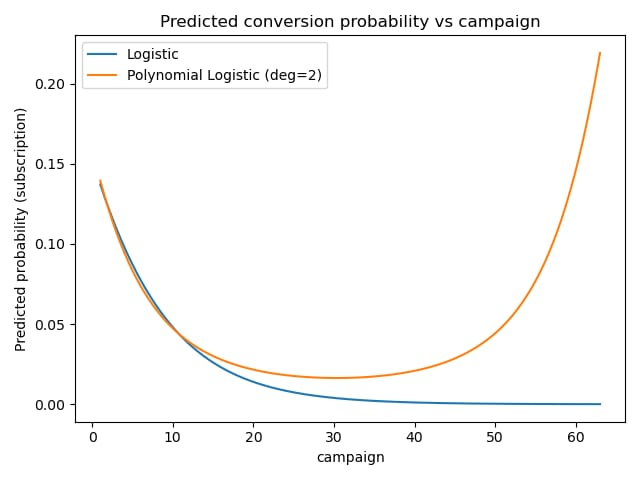